In [1]:
using NBInclude
@nbinclude("functions.ipynb")
function load_model_identity(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder decoder_last
    println("Done")
    return encoder_μ, encoder_logvar, decoder, decoder_last
    
end

function get_train_loader(batch_size, shuffle::Bool)
    # The MNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = MNIST.traindata(Float32)
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end


All function imported


┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:187


In [19]:


# pick a image in MNIST to denoise
num = 5
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x_true= x_batch[:,i];
# Load the model and test set loader incoherent
epoch_to_load_inco = 20
dir_inco = "trained_GNN/MNIST_identity_v2"
encoder_μ_inco, encoder_logvar_inco, decoder_inco, W3 = load_model_identity(dir_inco, epoch_to_load_inco);
μ = encoder_μ_inco(x_true)
logvar_inco = encoder_logvar_inco(x_true)
# Apply reparameterisation trick to sample latent
z_inco = μ + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco)


# Load the model and test set loader unenforced
epoch_to_load_co = 20
dir_co = "trained_GNN/MNIST"
encoder_μ_co, encoder_logvar_co, decoder_co = load_model(dir_co, epoch_to_load_co);
μ = encoder_μ_co(x_true)
logvar_co = encoder_logvar_co(x_true)
# Apply reparameterisation trick to sample latent
z_co = μ + randn(Float32, size(logvar_co)) .* exp.(0.5f0 * logvar_co)


#setup
x_dim = 784
k = 20
tolerance = 1e-7; max_iter = 3000; out_toggle = 0
opt = Flux.Optimise.ADAM(.1);




Loading model...Done


Loading model...Done


In [31]:
z_est_inco_list = []
z_est_co_list = []
G_inco(z) = W3 *decoder_inco(z)
G_co(z) = relu(Flux.params(decoder_co)[3] * relu(Flux.params(decoder_co)[2]*relu(Flux.params(decoder_co)[1]*z)))

m_list = 10:5:100
for m in m_list
    F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
    F_sub = F_sub * sqrt(x_dim)/sqrt(m); #normalization  

    y = F_sub * G_inco(z_inco) # measurement vector using subsampled DCT matrix
    z_est_inco = randn(k) #initialization for algorithm
    z_est_inco = estimated_code(opt, G_inco, y, F_sub, z_est_inco; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    push!(z_est_inco_list, z_est_inco)

    y = F_sub * G_co(z_co) # measurement vector using subsampled DCT matrix
    z_est_co = randn(k) #initialization for algorithm
    z_est_co = estimated_code(opt, G_co, y, F_sub, z_est_co; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    push!(z_est_co_list, z_est_co)
end



┌ Info: Saved animation to 
│   fn = /Users/babhru/Documents/GitHub/GNN_Isometries/anim_fpsnot5.gif
└ @ Plots /Users/babhru/.julia/packages/Plots/E2187/src/animation.jl:126


Plots.AnimatedGif("/Users/babhru/Documents/GitHub/GNN_Isometries/anim_fpsnot5.gif")
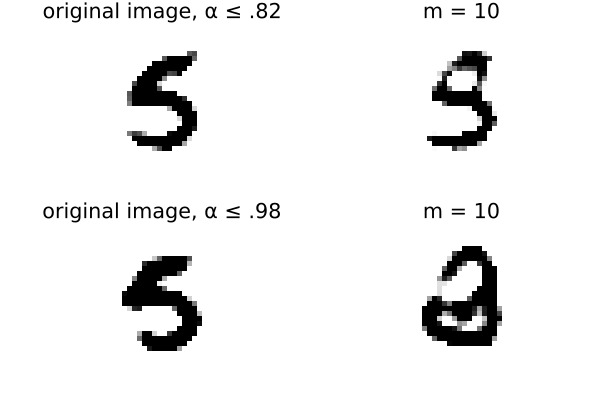

In [32]:
anim = @animate for k ∈ 1:length(m_list)
    p1 = plot(colorview(Gray, reshape(G_inco(z_inco), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .82")
    p2 = plot(colorview(Gray, reshape(G_inco(z_est_inco_list[k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    p3 = plot(colorview(Gray, reshape(G_co(z_co), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .98")
    p4 = plot(colorview(Gray, reshape(G_co(z_est_co_list[k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    plot(p1, p2, p3, p4, layout = grid(2,2))
end

gif(anim, "anim_fpsnot5.gif", fps = 1)

In [ ]:


# pick a image in MNIST to denoise
num = 5
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x_true= x_batch[:,i];
# Load the model and test set loader incoherent
epoch_to_load_inco = 20
dir_inco = "trained_GNN/MNIST_identity_v2"
encoder_μ_inco, encoder_logvar_inco, decoder_inco, W3 = load_model_identity(dir_inco, epoch_to_load_inco);
μ = encoder_μ_inco(x_true)
logvar_inco = encoder_logvar_inco(x_true)
# Apply reparameterisation trick to sample latent
z_inco = μ + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco)


# Load the model and test set loader unenforced
epoch_to_load_co = 20
dir_co = "trained_GNN/MNIST"
encoder_μ_co, encoder_logvar_co, decoder_co = load_model(dir_co, epoch_to_load_co);
μ = encoder_μ_co(x_true)
logvar_co = encoder_logvar_co(x_true)
# Apply reparameterisation trick to sample latent
z_co = μ + randn(Float32, size(logvar_co)) .* exp.(0.5f0 * logvar_co)


#setup
x_dim = 784
k = 20
tolerance = 1e-7; max_iter = 3000; out_toggle = 0
opt = Flux.Optimise.ADAM(.1);




In [ ]:
z_est_inco_list = []
z_est_co_list = []
G_inco(z) = W3 *decoder_inco(z)
G_co(z) = relu(Flux.params(decoder_co)[3] * relu(Flux.params(decoder_co)[2]*relu(Flux.params(decoder_co)[1]*z)))

m_list = 10:5:70
for m in m_list
    F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
    F_sub = F_sub * sqrt(x_dim)/sqrt(m); #normalization  

    y = F_sub * G_inco(z_inco) # measurement vector using subsampled DCT matrix
    z_est_inco = randn(k) #initialization for algorithm
    z_est_inco = estimated_code(opt, G_inco, y, F_sub, z_est_inco; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    push!(z_est_inco_list, z_est_inco)

    y = F_sub * G_co(z_co) # measurement vector using subsampled DCT matrix
    z_est_co = randn(k) #initialization for algorithm
    z_est_co = estimated_code(opt, G_co, y, F_sub, z_est_co; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    push!(z_est_co_list, z_est_co)
end

